# Programming Assignment 01 [50 marks]


This assignment will introduce you to:
1. Building and training a convolutional network
2. Saving snapshots of your trained model
3. Reloading weights from a saved model
4. Fine-tuning a pre-trained network
5. Visualizations using TensorBoardLogger

This code has been tested and should run for Python 3.7.10 with pytorch 1.7.0 and pytorch_lightning 1.2.0 in Google colab. The advantage of colab is that you can use GPUs for small codes that does not need very long runtime.

Details: (double-click here to fill)

Name: `Nisarg Upadhyaya`

Roll Number: `19CS30031`

Make sure to go through all the comments and texts in this notebook, as they contain specific instructions to complete the assignment. You would need to submit a single `.ipynb` file. Write your codes only between the START and END markers. All the required outputs must be embedded in the notebook itself. Feel free to reach out to the TAs through Piazza if you have any doubts. Happy coding (and learning)!

## Part 0: Tutorials

You will find these tutorials on pytorch and pytorch_lightning useful:
 - [Pytorch Tutorials](https://pytorch.org/tutorials/) - "Learn the Basics" is very good starter
 - [Pytorch-lightning masterclass](https://www.youtube.com/playlist?list=PLaMu-SDt_RB5NUm67hU2pdE75j6KaIOv2) - around 140 minutes of videos
 - [deep-learning-project-template](https://github.com/PyTorchLightning/deep-learning-project-template/blob/master/project/lit_image_classifier.py) - You will find this project template from the official pytorch-lightning repo very useful. We have, mostly, tried to follow this template for this assignment.

## Part 1: Building and training a Residual Network Model (ResNet) ⚛

First, get the data to the working folder.
The drive links for the required data are as follows:

Tiny ImageNet - https://drive.google.com/file/d/1VO2ooFlzw6VD2P5hx535V0Rlbo9C6ldc/view?usp=sharing

Office-31 Amazon - https://drive.google.com/file/d/1I5GMKCH3mQ8NJypeZnuxTG7k43xdA02o/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy the data and unzip it in the working folder
!scp /content/drive/MyDrive/Office31_Amazon.zip ./
!scp /content/drive/MyDrive/Tiny_ImageNet_200.zip ./
!unzip Office31_Amazon.zip
!unzip Tiny_ImageNet_200.zip

Streaming output truncated to the last 5000 lines.
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_406.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_388.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_440.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_410.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_261.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_216.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_401.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_252.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_450.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_467.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_468.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_37.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n02699494_361.JPEG  
  inflating: Tiny-ImageNet-200/n02699494/images/n0269

In [3]:
# install pytorch lighting
! pip install pytorch-lightning --quiet

     |████████████████████████████████| 527 kB 4.3 MB/s 
     |████████████████████████████████| 133 kB 53.2 MB/s 
     |████████████████████████████████| 829 kB 49.9 MB/s 
     |████████████████████████████████| 397 kB 45.1 MB/s 
     |████████████████████████████████| 952 kB 39.0 MB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 1.1 MB 36.4 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 40.8 MB/s 
     |████████████████████████████████| 144 kB 51.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
# List of imports
from PIL import Image
from typing import Type, Any, Callable, Union, List, Optional

## PyTorch
import torch
from torch import Tensor
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## PyTorch lightning
import pytorch_lightning as pl
import torchmetrics
# Torchvision
import torchvision
from torchvision import transforms

# import TensorBoardLogger
from pytorch_lightning.loggers import TensorBoardLogger

In the following blocks of code we will design a ResNet block with `Bottleneck`. These are the building blocks for the network, and depending on the number of blocks in various layers, the models are classified as resnet50, resnet101, resnet152, etc.

Let us first understand the detailed architecture of resnet:



```
ResNet(
  (conv1)
  (bn1)
  (relu)
  (maxpool)
  (layer1) # constituted of multiple Bottleneck blocks
  (layer2) # constituted of multiple Bottleneck blocks
  (layer3) # constituted of multiple Bottleneck blocks
  (layer4) # constituted of multiple Bottleneck blocks
  (avgpool)
  (fc)
)
```







In the image below, the schematic representation of a bottleneck block is represented. The left part of the diagram shows a `Bottleneck` block without identity downsampling, while the right part includes identity downsampling, which is incorporated to match the channel dimension of the left and right paths. Although the name 'downsampling' doesn't necessarily imply reduction of spatial dimensions of the feature maps. `f` represents the number of channels in the output of that particular layer (`out_channels` aka `out_planes`). Note the `4f` in the final convolution layer in the left path of each of the figures: in ResNet, each block has an expansion parameter in order to increase the `out_channels` if needed.

Suppose a given layer consists of `n` `Bottleneck` blocks, then the first block should include identity downsampling, while the rest of the `n-1` blocks should not. 

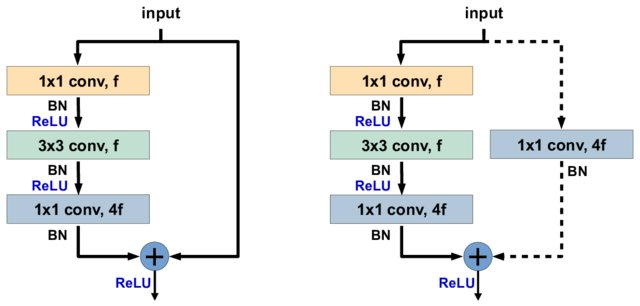

In [5]:
# helper functions to return 3x3 and 1x1 convolution 2d layers
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

Now, we will design the Bottleneck block in the following class, which is used to build the ResNet network in the cell following the current cell. You may have a look of that code to understand how this Bottleneck class will be used.

12 marks [6 + 6]

In [6]:
class Bottleneck(nn.Module):

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        downsample: Optional[nn.Module] = None, # Should be true only for the first block of each layer
        stride: int = 1, # Need not change this value
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
    ) -> None:
        super().__init__()

        norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups

        ###################################
        ####   Code required (START)   ####
        ###################################
        # Declare all the required elemental layers here.
        # Make sure to call the functions with the stride, groups, dilation arguments
        # conv1 [inplanes->width], 
        # bn1 [width], 
        # conv2 [width->width], 
        # bn2 [width], 
        # conv3 [width->planes*expansion], 
        # bn3 [planes*expansion], 
        # relu activation, 
        # downsample layer 
        
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        # Select activation layer accordingly
        # self.relu = nn.Tanh()
        self.relu = nn.ReLU(inplace = True)
        # self.relu = nn.LeakyReLU(inplace = True)
        self.downsample = downsample

        ###################################
        ####   Code required (END)   ####
        ###################################

        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:

        ###################################
        ####   Code required (START)   ####
        ###################################
        # Implement the forward pass here for the block.
        # Given the input tensor x it should provide the block output.

        # First conv
        temp = self.conv1(x)
        temp = self.bn1(temp)
        temp = self.relu(temp)

        # Second conv
        temp = self.conv2(temp)
        temp = self.bn2(temp)
        temp = self.relu(temp)

        # Third conv
        temp = self.conv3(temp)
        temp = self.bn3(temp)

        original = x
        if self.downsample != None:
            original = self.downsample(x)
        
        return self.relu(temp + original)

        ###################################
        ####   Code required (END)   ####
        ###################################

8 marks [6 + 1 + 1]

In [7]:
class ResNet(nn.Module): # Here we build the network. Go through the code in detail to learn how it is built.
    def __init__(
        self,
        block: Type[Bottleneck],
        layers: List[int],
        num_classes: int = 200,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64):
        super().__init__()
        
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        replace_stride_with_dilation = [False, False, False]

        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        # Select activation layer accordingly
        # self.relu = nn.Tanh()
        self.relu = nn.ReLU(inplace = True)
        # self.relu = nn.LeakyReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer( # this function builds a layer
        self,
        block: Type[Bottleneck],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, downsample, stride, self.groups, self.base_width, previous_dilation)
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, planes, groups=self.groups, base_width=self.base_width, dilation=self.dilation)
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        ###################################
        ####   Code required (START)   ####
        ###################################
        # Implement the forward pass here for the resnet network.

        temp = self.conv1(x)
        temp = self.bn1(temp)
        temp = self.relu(temp)
        temp = self.maxpool(temp)
        temp = self.layer1(temp)
        temp = self.layer2(temp)
        temp = self.layer3(temp)
        temp = self.layer4(temp)
        temp = self.avgpool(temp)
        temp = torch.flatten(temp, 1)
        return self.fc(temp)

        ###################################
        ####   Code required (END)   ####
        ###################################

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Bottleneck],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


# the number of Bottleneck block across the layers are given for the following networks:
# resnet50: 3 in layer1, 4 in layer2, 6 in layer3, 3 in layer4
# resnet101: 3 in layer1, 4 in layer2, 23 in layer3, 3 in layer4
# resnet152: 3 in layer1, 8 in layer2, 36 in layer3, 3 in layer4

# the following functions design resnet50, resnet101, resnet152 and return it to us.
# we have completed the function for resnet50.
# you need to do it for resnet101 and resnet152.

def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet("resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    ###################################
    ####   Code required (START)   ####
    ###################################

    return _resnet("resnet101", Bottleneck, [3, 4, 23, 3], pretrained, progress, **kwargs)

    ###################################
    ####   Code required (END)   ####
    ###################################



def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    ###################################
    ####   Code required (START)   ####
    ###################################

    return _resnet("resnet152", Bottleneck, [3, 8, 36, 3], pretrained, progress, **kwargs)

    ###################################
    ####   Code required (END)   ####
    ###################################

10 marks [1 + 3 + 3 + 3]

In [8]:
class My_ResNet_Classifier(pl.LightningModule):
    def __init__(self, backbone_name, act_fn, num_classes=200, learning_rate=1e-3):
        '''
        backbone_name: which resnet classifier to use - choose from "resnet50", "resnet101", "resnet152"

        act_fn: Is a tuple whose first member is "key" and second one is the "value".
        "key" has to be all lowercase and one of the three options - "relu", "tanh", "leakyrelu".
        "value" has to be correspondingly one of the followings - nn.ReLU, nn.Tanh, nn.LeakyRelu.
        This is required for idiosyncracies in Kaiming_normal initialization.
        
        num_classes: Number of classes in the dataset which equivalently is the number of output nodes
        
        learning_rate: The learning rate hyperparameter
        '''
        super().__init__()
        # 'save_hyperparameters' saves the values of anything in the __init__ for us to the checkpoint.
        # This is a useful feature.
        self.save_hyperparameters()

        if backbone_name == "resnet50":
          self.backbone = resnet50(pretrained=False)
        elif backbone_name == "resnet101":
          self.backbone = resnet101(pretrained=False)
        elif backbone_name == "resnet152":
          self.backbone = resnet152(pretrained=False)
        
        self.num_classes = num_classes
        self.act_fn = act_fn[1]
        self.act_fn_name = act_fn[0]
        self.accuracy = torchmetrics.Accuracy()
    
    # Bit of detail that you can skip. Basically these are standard practice of initialization depending on
    # the type of conv operation and batch-normalization
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.act_fn_name) # self.hparams.act_fn
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # use forward for inference/predictions

        x = self.backbone(x)
        
        ###################################
        ####    Code required (end)    ####
        ###################################
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        # Logging training loss on each training step and also on each epoch
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        
        ###################################
        ####   Code required (start)   ####
        ###################################
        # get the predictions, find accuracy, and log it.

        acc = self.accuracy(logits.softmax(dim = -1), y)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        ###################################
        ####    Code required (end)    ####
        ###################################
        return loss
    
    def validation_step(self, batch, batch_idx):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the validation step here.
        # Make sure to log the val_loss and val_acc as you did in the training step

        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, logger=True)

        acc = self.accuracy(logits.softmax(dim = -1), y)
        self.log('val_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        ###################################
        ####    Code required (end)    ####
        ###################################

        return loss
    
    def test_step(self, batch, batch_idx):
        ###################################
        ####   Code required (start)   ####
        ###################################
        # Implement the test step here.
        # Make sure to log the test_loss and test_acc.
        # Code is very similar to that of the validation step.

        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, logger=True)

        acc = self.accuracy(logits.softmax(dim = -1), y)
        self.log('test_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        ###################################
        ####    Code required (end)    ####
        ###################################
        return loss
    
    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)



---
The following cell sets up the dataset with some preliminary data augmentation, the model and the logger. We will first, train our ResNet on the [Tiny ImageNet Dataset](https://www.kaggle.com/c/tiny-imagenet).

---




In [ ]:
# Setting the seed for reproducibility
pl.seed_everything(101)

# ------------
# args
# ------------
# Path to the folder where the Tiny ImageNet dataset is/will be downloaded

DATASET_PATH = "/content/Tiny-ImageNet-200/"
# Choice of activation functions as dict
act_fn_dict = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU
}

# ------------
# data
# ------------

# As we have learned in the class, it is important to have the data preprocessed with a zero mean. 
# The following values are the mean and std for tiny-imagenet:
DATA_MEANS = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]
print("Mean of data:", DATA_MEANS)
print("Standard deviation of data:", DATA_STD)

# We will use the mean and standard deviation of the input data computed above to normalize the input.

# Note that the above normalization will be applied to both test/valiadtion and traning data. The training data,
# in addition, will need to go through a few more data augmentations. We plan to use following data augmentations.
# 1. Random horizontal flip with 50% probability - RandomHorizontalFlip
# 2. Crop the image to random size and aspect ratio. This crop is finally resized to given size - RandomResizedCrop
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((64,64),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Next we will split the training data into training and validation. You will notice that we use the same command
# in the next two lines. This is a trick, often used to make sure that training data uses the random data augmentations
# while validation data do not.

tiny_imagenet_dataset_train = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
tiny_imagenet_dataset_val_test = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=test_transform)
# declared the same thing multiple times because of different transforms. just a hack (inefficient though)
num_imgs = len(tiny_imagenet_dataset_train)
print("Total number of images:", num_imgs)

# Let's split the dataset as: train: 65%, val: 10%, test: 25%.
train_length = int(0.65*num_imgs)
val_length = int(0.1*num_imgs)
test_length = num_imgs - train_length - val_length

print(train_length, val_length, test_length)

train_set, _, _ = data.random_split(tiny_imagenet_dataset_train, [train_length, val_length, test_length])
_, val_set, test_set = data.random_split(tiny_imagenet_dataset_val_test, [train_length, val_length, test_length])

# Define a set of data loaders
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# ------------
# model
# ------------
# We will use a ResNet-50 model for this assignment. 
# You may try experimenting with ResNet-101 and ResNet-152 to find out
# But, training these larger networks will demand more computation and memory requirements.
# the effect of depth in the performance of a neural network.
model = My_ResNet_Classifier(backbone_name="resnet50", act_fn=("tanh",act_fn_dict["tanh"]), num_classes=200, learning_rate=1e-3)
# ------------
# logging
# ------------
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/tb_logs', 'tiny-imagenet', 'tanh')

# ------------
# training
# ------------
# Initialize a trainer
trainer = pl.Trainer(max_epochs=20,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

Global seed set to 101


Mean of data: [0.485, 0.456, 0.406]
Standard deviation of data: [0.229, 0.224, 0.225]
Total number of images: 100000
65000 10000 25000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecat

In [ ]:
# Train the model
# model.backbone.relu = nn.Tanh()
# model.backbone.layer1.relu = nn.Tanh()
# model.backbone.layer2.relu = nn.Tanh()
# model.backbone.layer3.relu = nn.Tanh()
# model.backbone.layer4.relu = nn.Tanh()
trainer.fit(model, train_loader, val_loader)
# expect a per epoch time taken to be around 3.5 minutes (on Colab using GPU backend)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | backbone | ResNet   | 23.9 M
1 | accuracy | Accuracy | 0     
--------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.671    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 101


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

3 marks

In [ ]:
###################################
####   Code required (start)   ####
###################################
# Write the code to save the checkpoint
# corresponding to Tanh activation
# function and show the evaluation
# results on validation and test set
# for the same

tanh_validation = trainer.validate(model, val_loader)
tanh_test = trainer.test(model, test_loader)

print(tanh_validation)
print(tanh_test)

trainer.save_checkpoint('/content/drive/MyDrive/checkpoints/tanh.ckpt')

###################################
####    Code required (end)    ####
###################################

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.2689000070095062,
 'val_acc_epoch': 0.2689000070095062,
 'val_loss': 3.206847667694092,
 'val_loss_epoch': 3.206847667694092}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.2709999978542328,
 'test_acc_epoch': 0.2709999978542328,
 'test_loss': 3.21860933303833,
 'test_loss_epoch': 3.21860933303833}
--------------------------------------------------------------------------------
[{'val_loss': 3.206847667694092, 'val_loss_epoch': 3.206847667694092, 'val_acc': 0.2689000070095062, 'val_acc_epoch': 0.2689000070095062}]
[{'test_loss': 3.21860933303833, 'test_loss_epoch': 3.21860933303833, 'test_acc': 0.2709999978542328, 'test_acc_epoch': 0.2709999978542328}]


Training ResNet on Tiny ImageNet with different activation functions and different epochs.
Complete the following tasks:
1.   Train the network with 3 different activation functions - Tanh, ReLU and LeakyReLU. You will see that a python dictionary __act_fn_dict__ is already provided above for this purpose. Each should be trained for 20 epochs. You do not need to write additional code for this part. You just need to play with the setup code.
2.   Save the three checkpoints above.
3.   Show the evaluation results (i.e., print the validation accuracy and test accuracy) of each of the three checkpoints above.




3 marks

In [ ]:
###################################
####   Code required (start)   ####
###################################
# Train using ReLU then
# Write the code to save the checkpoint
# corresponding to ReLU activation
# function and show the evaluation
# results on validation and test set
# for the same

model = My_ResNet_Classifier(backbone_name="resnet50", act_fn=("relu",act_fn_dict["relu"]), num_classes=200, learning_rate=1e-3)
TensorBoard_Logger = TensorBoardLogger('/content/tb_logs', 'tiny-imagenet', 'relu')

trainer = pl.Trainer(max_epochs=20,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

# model.backbone.relu = nn.ReLU()
# model.backbone.layer1.relu = nn.ReLU()
# model.backbone.layer2.relu = nn.ReLU()
# model.backbone.layer3.relu = nn.ReLU()
# model.backbone.layer4.relu = nn.ReLU()
trainer.fit(model, train_loader, val_loader)

relu_validation = trainer.validate(model, val_loader)
relu_test = trainer.test(model, test_loader)

print(relu_validation)
print(relu_test)

trainer.save_checkpoint('/content/drive/MyDrive/checkpoints/relu.ckpt')

###################################
####    Code required (end)    ####
###################################

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | backbone | ResNet   | 23.9 M
1 | accuracy | Accuracy | 0     
--------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.671    Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 101


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.7235000133514404,
 'val_acc_epoch': 0.7235000133514404,
 'val_loss': 1.7818562984466553,
 'val_loss_epoch': 1.7818562984466553}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.713919997215271,
 'test_acc_epoch': 0.713919997215271,
 'test_loss': 1.8299469947814941,
 'test_loss_epoch': 1.8299469947814941}
--------------------------------------------------------------------------------
[{'val_loss': 1.7818562984466553, 'val_loss_epoch': 1.7818562984466553, 'val_acc': 0.7235000133514404, 'val_acc_epoch': 0.7235000133514404}]
[{'test_loss': 1.8299469947814941, 'test_loss_epoch': 1.8299469947814941, 'test_acc': 0.713919997215271, 'test_acc_epoch': 0.713919997215271}]


3 marks

In [ ]:
###################################
####   Code required (start)   ####
###################################
# Train using LeakyReLU then
# Write the code to save the checkpoint
# corresponding to LeakyReLU activation
# function and show the evaluation
# results on validation and test set
# for the same

model = My_ResNet_Classifier(backbone_name="resnet50", act_fn=("leaky_relu",act_fn_dict["leaky_relu"]), num_classes=200, learning_rate=1e-3)
TensorBoard_Logger = TensorBoardLogger('/content/tb_logs', 'tiny-imagenet', 'leaky_relu')

trainer = pl.Trainer(max_epochs=20,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

# model.backbone.relu = nn.LeakyReLU()
# model.backbone.layer1.relu = nn.LeakyReLU()
# model.backbone.layer2.relu = nn.LeakyReLU()
# model.backbone.layer3.relu = nn.LeakyReLU()
# model.backbone.layer4.relu = nn.LeakyReLU()
trainer.fit(model, train_loader, val_loader)

leaky_relu_validation = trainer.validate(model, val_loader)
leaky_relu_test = trainer.test(model, test_loader)

print(leaky_relu_validation)
print(leaky_relu_test)

trainer.save_checkpoint('/content/drive/MyDrive/checkpoints/leaky_relu.ckpt')

###################################
####    Code required (end)    ####
###################################

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | backbone | ResNet   | 23.9 M
1 | accuracy | Accuracy | 0     
--------------------------------------
23.9 M    Trainable params
0         Non-trainable params
23.9 M    Total params
95.671    Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 101


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6988000273704529,
 'val_acc_epoch': 0.6988000273704529,
 'val_loss': 1.8475004434585571,
 'val_loss_epoch': 1.8475004434585571}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.6867600083351135,
 'test_acc_epoch': 0.6867600083351135,
 'test_loss': 1.8506391048431396,
 'test_loss_epoch': 1.8506391048431396}
--------------------------------------------------------------------------------
[{'val_loss': 1.8475004434585571, 'val_loss_epoch': 1.8475004434585571, 'val_acc': 0.6988000273704529, 'val_acc_epoch': 0.6988000273704529}]
[{'test_loss': 1.8506391048431396, 'test_loss_epoch': 1.8506391048431396, 'test_acc': 0.6867600083351135, 'test_acc_epoch': 0.6867600083351135}]


## Part 2: Loading a pretrained model and finetuning on Office31 dataset

[Office Dataset:](https://faculty.cc.gatech.edu/~judy/domainadapt/#datasets_code)
Contains 3 domains Amazon, Webcam, and Dslr. Each contain images from amazon.com, or office environment images taken with varying lighting and pose changes using a webcam or a dslr camera, respectively. Contains 31 categories in each domain. We will just use the Amazon domain for our assignment.

1 mark

In [ ]:
# Load the checkpoint which gave the best validation accuracy of the three models you trained above.
# This will be our pretrained model to start with
###################################
####   Code required (start)   ####
###################################
# Load checkpoint with best validation accuracy

def get_val_acc(ckpt_path, val_loader):
    model = My_ResNet_Classifier.load_from_checkpoint(ckpt_path)
    # model.backbone.relu = act_fn()
    # model.backbone.layer1.relu = act_fn()
    # model.backbone.layer2.relu = act_fn()
    # model.backbone.layer3.relu = act_fn()
    # model.backbone.layer4.relu = act_fn()
    trainer = pl.Trainer(gpus = 1)
    return trainer.validate(model, val_loader)[0]['val_acc_epoch']

best_ckpt_path = '/content/drive/MyDrive/checkpoints/tanh.ckpt'
best_val_acc = get_val_acc(best_ckpt_path, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.2689000070095062,
 'val_acc_epoch': 0.2689000070095062,
 'val_loss': 3.206847906112671,
 'val_loss_epoch': 3.206847906112671}
--------------------------------------------------------------------------------


In [ ]:
relu_val_acc = get_val_acc('/content/drive/MyDrive/checkpoints/relu.ckpt', val_loader)

if relu_val_acc > best_val_acc:
    best_ckpt_path = '/content/drive/MyDrive/checkpoints/relu.ckpt'
    best_val_acc = relu_val_acc

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.7235000133514404,
 'val_acc_epoch': 0.7235000133514404,
 'val_loss': 1.7818557024002075,
 'val_loss_epoch': 1.7818557024002075}
--------------------------------------------------------------------------------


In [ ]:
leaky_relu_val_acc = get_val_acc('/content/drive/MyDrive/checkpoints/leaky_relu.ckpt', val_loader)

if leaky_relu_val_acc > best_val_acc:
    best_ckpt_path = '/content/drive/MyDrive/checkpoints/leaky_relu.ckpt'
    best_val_acc = leaky_relu_val_acc

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.6988000273704529,
 'val_acc_epoch': 0.6988000273704529,
 'val_loss': 1.847499966621399,
 'val_loss_epoch': 1.847499966621399}
--------------------------------------------------------------------------------


In [10]:
print(f"Path of best accuracy checkpoint: {best_ckpt_path}")
# Based on whichever gives best accuracy, select that as the activation function in Bottleneck and ResNet
model = My_ResNet_Classifier.load_from_checkpoint(best_ckpt_path)

###################################
####    Code required (end)    ####
###################################

Path of best accuracy checkpoint: /content/drive/MyDrive/checkpoints/relu.ckpt


3 marks

In [11]:
# In this cell we will freeze the initial layers of the resnet50 network
# Just keep the layer4 and the fc layer trainable
# Make sure to change the output dimension of the fc layer from 200 to 31 as Office31 now has 31 categories to classify (Important!)
###################################
####   Code required (start)   ####
###################################
# freeze params

for param in model.backbone.conv1.parameters():
    param.requires_grad = False

for param in model.backbone.bn1.parameters():
    param.requires_grad = False

for param in model.backbone.relu.parameters():
    param.requires_grad = False

for param in model.backbone.maxpool.parameters():
    param.requires_grad = False

for param in model.backbone.layer1.parameters():
    param.requires_grad = False

for param in model.backbone.layer2.parameters():
    param.requires_grad = False

for param in model.backbone.layer3.parameters():
    param.requires_grad = False

for param in model.backbone.avgpool.parameters():
    param.requires_grad = False

model.backbone.fc = nn.Linear(2048, 31)

###################################
####    Code required (end)    ####
###################################

3 marks

In [12]:
# ------------
# Office-31 dataset preparation
# ------------
# Path to the folder where the Office31 dataset is/will be downloaded
DATASET_PATH = "/content/Office31_Amazon"

DATA_MEANS = [0.485, 0.456, 0.406]
DATA_STD = [0.229, 0.224, 0.225]
print("Mean of data:", DATA_MEANS)
print("Standard deviation of data:", DATA_STD)


###################################
####   Code required (start)   ####
###################################
# In a same way as we did for tiny-imagenet above, for Office-31
# Define the train and test transforms - keep them same as tiny-imagenet as above
# Define the datasets using ImageFolder
# Split the dataset into train, val, and test in ratio 70%, 10%, 20%
# Define the dataloaders

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((64,64),scale=(0.8,1.0),ratio=(0.85,1.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

# Resize to (64, 64) 
test_transform = transforms.Compose([transforms.Resize((64, 64)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

tiny_imagenet_dataset_train = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=train_transform)
tiny_imagenet_dataset_val_test = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=test_transform)
num_imgs = len(tiny_imagenet_dataset_train)
print("Total number of images:", num_imgs)

train_length = int(0.70*num_imgs)
val_length = int(0.10*num_imgs)
test_length = num_imgs - train_length - val_length

print(train_length, val_length, test_length)

train_set, _, _ = data.random_split(tiny_imagenet_dataset_train, [train_length, val_length, test_length])
_, val_set, test_set = data.random_split(tiny_imagenet_dataset_val_test, [train_length, val_length, test_length])

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

###################################
####   Code required (end)   ####
###################################

Global seed set to 101


Mean of data: [0.485, 0.456, 0.406]
Standard deviation of data: [0.229, 0.224, 0.225]
Total number of images: 2806
1964 280 562


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In the next cell, you will write code to fine-tune the model that you loaded a few cells back on Office31 for 10 epochs. Note that the TensorBoardLogger is initiated once more here so that the secondary directory to store the logs is 'Office31' instead of 'Tiny ImageNet'.

2 marks

In [13]:
# Initialize Tensorboard logger
TensorBoard_Logger = TensorBoardLogger('/content/tb_logs', 'office31', 'relu_freeze')

###################################
####   Code required (start)   ####
###################################
# Define the trainer
# Train the model on Office-31 for 10 epochs.

trainer = pl.Trainer(max_epochs=10,
                    progress_bar_refresh_rate=20, 
                    gpus=1,
                    logger=TensorBoard_Logger)

trainer.fit(model, train_loader, val_loader)

# expect a per epoch time taken to be around 20 seconds (on Colab using GPU backend)

###################################
####    Code required (end)    ####
###################################

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | backbone | ResNet   | 23.6 M
1 | accuracy | Accuracy | 0     
--------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.6 M    Total params
94.286    Total estimated mode

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Global seed set to 101
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2 marks

In [14]:
###################################
####   Code required (start)   ####
###################################
# Test the fine-tuned model on validation and test set and print the values obtained

trainer.validate(model, val_loader)
trainer.test(model, test_loader)

###################################
####    Code required (end)    ####
###################################

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8857142925262451,
 'val_acc_epoch': 0.8857142925262451,
 'val_loss': 0.48898303508758545,
 'val_loss_epoch': 0.48898303508758545}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8896797299385071,
 'test_acc_epoch': 0.8896797299385071,
 'test_loss': 0.5084708333015442,
 'test_loss_epoch': 0.5084708333015442}
--------------------------------------------------------------------------------


[{'test_acc': 0.8896797299385071,
  'test_acc_epoch': 0.8896797299385071,
  'test_loss': 0.5084708333015442,
  'test_loss_epoch': 0.5084708333015442}]

In [ ]:
# Show tensorboard plots
%reload_ext tensorboard
%tensorboard --logdir /content/tb_logs/